
<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio de Sistemas de Recomendación

## Objetivos del Laboratorio

1.	Implementar y comparar diferentes tipos de sistemas de recomendación utilizando datos reales.

2.	Explorar el impacto de las características de los datos en la calidad de las recomendaciones.

3.	Desarrollar habilidades en preprocesamiento, modelado y evaluación de sistemas de recomendación.

## Los Datos


- **1. games_description.csv**: Este archivo contiene información detallada sobre videojuegos disponibles en una tienda. Las columnas que tenemos son: 


	- **`name`**: Nombre del videojuego.

	- **`short_description`**: Breve descripción del videojuego.

	- **`long_description`**: Descripción completa y detallada del videojuego.

	- **`genres`**: Lista de géneros asociados al videojuego (por ejemplo, Acción, RPG).

	- **`minimum_system_requirement`**: Requisitos mínimos para ejecutar el videojuego.

	- **`recommend_system_requirement`**: Requisitos recomendados para ejecutar el videojuego.

	- **`release_date`**: Fecha de lanzamiento del videojuego.

	- **`developer`**: Nombre del desarrollador del videojuego.

	- **`publisher`**: Nombre del publicador del videojuego.

	- **`overall_player_rating`**: Calificación general de los jugadores (categórica).

	- **`number_of_reviews_from_purchased_people`**: Número de reseñas realizadas por personas que compraron el juego.

	- **`number_of_english_reviews`**: Número de reseñas en inglés.

	- **`link`**: Enlace al videojuego en la tienda.


- **2. games_ranking.csv**: Este archivo contiene información sobre el ranking de videojuegos basados en diferentes métricas. Las columnsa que tenemos son:


	- **`game_name`**: Nombre del videojuego.

	- **`genre`**: Género principal del videojuego.

	- **`rank_type`**: Tipo de ranking (por ejemplo, ventas, popularidad).

	- **`rank`**: Posición del videojuego en el ranking correspondiente.

----

- Los datos del archivo `games_description.csv` pueden utilizarse para construir sistemas de recomendación basados en contenido.
- Los datos del archivo `games_ranking.csv` son ideales para implementar sistemas basados en popularidad.

## Los problemas

A lo largo de este laboratorio deberás enfrentarte a distintos casos prácticos:



In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Para visualización de datos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Para cargar los datos
# -----------------------------------------------------------------------
import pickle

# Para sistemas de recomendacion basados en cotenido
# -----------------------------------------------------------------------
from sklearn.feature_extraction.text import CountVectorizer # Vectorizacion / tokenizacion 
from sklearn.metrics.pairwise import cosine_similarity #  Cosine Similarity post Vectorizacion

# Importamos nuestras funciones
# -----------------------------------------------------------------------
from src import soporte_sistemas_recomendacion as sr

# Configuración de pandas
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None)

# **Caso 1: Sistema de Recomendación Basado en Contenido**

Debes construir un sistema que recomiende videojuegos similares basándose en su descripción y géneros. Para eso deberás:

- Preprocesar las descripciones de los juegos (texto) utilizando técnicas de NLP aprendidas durante la clase.

- Extraer y limpiar las etiquetas de género para su uso en el sistema de recomendación.

- Implementar una métrica de similitud (como el coseno) para recomendar juegos similares.

- Evaluar las recomendaciones generadas para un conjunto de juegos específicos.



In [2]:
df = pd.read_csv("datos/games_description.csv")
df.sample()

,name,short_description,long_description,genres,minimum_system_requirement,recommend_system_requirement,release_date,developer,publisher,overall_player_rating,number_of_reviews_from_purchased_people,number_of_english_reviews,link
82,Little Nightmares II,Little Nightmares II is a suspense adventure g...,About This Game\nA host of brand-new Residents...,"['Horror', 'Adventure', 'Singleplayer', 'Puzzl...",['Requires a 64-bit processor and operating sy...,['Requires a 64-bit processor and operating sy...,"10 Feb, 2021",['Tarsier Studios'],['BANDAI NAMCO Entertainment'],Very Positive,"(31,751)","14,237",https://store.steampowered.com/app/860510/Litt...


In [3]:
df.isnull().sum()

name                                        0
short_description                          13
long_description                            0
genres                                      0
minimum_system_requirement                  0
recommend_system_requirement                0
release_date                                0
developer                                   0
publisher                                   0
overall_player_rating                       0
number_of_reviews_from_purchased_people     0
number_of_english_reviews                   0
link                                        0
dtype: int64

In [4]:
df.dropna(subset="short_description",inplace=True)
df.isnull().sum()

name                                       0
short_description                          0
long_description                           0
genres                                     0
minimum_system_requirement                 0
recommend_system_requirement               0
release_date                               0
developer                                  0
publisher                                  0
overall_player_rating                      0
number_of_reviews_from_purchased_people    0
number_of_english_reviews                  0
link                                       0
dtype: int64

###  Preprocesar las descripciones de los juegos (texto) utilizando técnicas de NLP aprendidas durante la clase
- Voy a usar short_description, ¿porque?
- long_description aporta:
    - Ruido excesivo: Mucho texto jaja
    - Demasiada dimensionalidad: Mucho texto en resumen
    - Menor Relevancia al Usuario: Al final del día un usuario no se lee las instrucciones del champú

Reduzco el número de columnas del df

In [5]:
reduced_df = df[["name","short_description","genres","overall_player_rating","number_of_reviews_from_purchased_people"]]

In [6]:
documento = reduced_df["short_description"]
vectorize = CountVectorizer()
X = vectorize.fit_transform(documento)

In [7]:
print(vectorize.get_feature_names_out())
print(X.toarray())

['000' '000th' '10' ... 'тепер' 'частині' 'черга']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [8]:
print(vectorize.get_feature_names_out())
for k,v in dict(zip(documento,X.toarray())).items():
    print(f"{v} -> {k}")
    break

['000' '000th' '10' ... 'тепер' 'частині' 'черга']
[0 0 0 ... 0 0 0] -> Black Myth: Wukong is an action RPG rooted in Chinese mythology. You shall set out as the Destined One to venture into the challenges and marvels ahead, to uncover the obscured truth beneath the veil of a glorious legend from the past.


### Extraer y limpiar las etiquetas de género para su uso en el sistema de recomendación.

Vamos a extraer los elementos de cada lista y a sacar una lista de géneros únicos

In [9]:
dictio_unicos = {}
for genre in reduced_df["genres"]:
    genre = genre.replace("[","").replace("]","").replace("'","").split(", ")
    for g in genre:
        if g.lower() not in dictio_unicos:
            dictio_unicos[g.lower()] = 1
        else:
            dictio_unicos[g.lower()] += 1

unique_genres = list(dictio_unicos.keys())

### Implementar una métrica de similitud (como el coseno) para recomendar juegos similares.

In [10]:
similarity = cosine_similarity(X)
similarity[:20]

array([[1.        , 0.44104677, 0.43684888, ..., 0.40406102, 0.43422596,
        0.34920635],
       [0.44104677, 1.        , 0.31665025, ..., 0.29939248, 0.29301636,
        0.24698619],
       [0.43684888, 0.31665025, 1.        , ..., 0.40291148, 0.35257807,
        0.34188173],
       ...,
       [0.32575152, 0.30488637, 0.34875922, ..., 0.29095719, 0.26801008,
        0.3086067 ],
       [0.47974861, 0.40450472, 0.41569898, ..., 0.38602432, 0.37174221,
        0.36394722],
       [0.09245003, 0.08807354, 0.11062442, ..., 0.02801659, 0.09032446,
        0.03962144]])

### Evaluar las recomendaciones generadas para un conjunto de juegos específicos.

Para que todo funcione, debemos renombrar la columna name a title

In [11]:
reduced_df = reduced_df.rename(columns={"name": "title"})

In [12]:
# definimos el juego
juego_usuario = reduced_df["title"].sample().values[0]

# buscamos el indice del juego
game_index = sr.get_index_from_title(juego_usuario, reduced_df)

# sacamos los juegos similares
similar_games = list(enumerate(similarity[game_index]))
similar_games[:3]

[(0, np.float64(0.0)),
 (1, np.float64(0.0422200330920749)),
 (2, np.float64(0.0))]

In [13]:
# ordenamos los resultados
juegos_similares_ordenadas = sorted(similar_games,key=lambda x:x[1],reverse=True)[1:21] # [1:21] si lo cambiamos a [0:21] la tenemos a ella misma 
juegos_similares_ordenadas[:3]

[(257, np.float64(0.1266600992762247)),
 (265, np.float64(0.11776030079682895)),
 (231, np.float64(0.10050378152592121))]

In [14]:
reduced_df.reset_index(inplace=True)

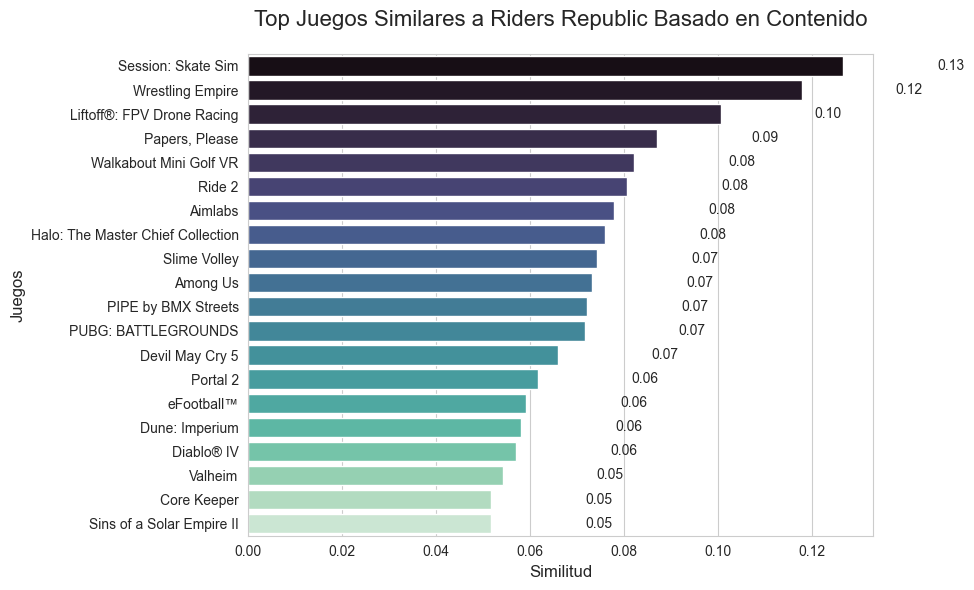

In [15]:
# y ahora buscamos el título
top_similar_games = {}
for i in juegos_similares_ordenadas:
    top_similar_games[sr.get_title_from_index(i[0], reduced_df)] = i[1]

# visualizamos los resultados
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Crear gráfico de barras
sns.barplot(
    x=list(top_similar_games.values()), 
    y=list(top_similar_games.keys()), 
    hue = list(top_similar_games.keys()),
    palette="mako"
)

# Añadir etiquetas y título
plt.title(f"Top Juegos Similares a {juego_usuario} Basado en Contenido", fontsize=16, pad=20)
plt.xlabel("Similitud", fontsize=12)
plt.ylabel("Juegos", fontsize=12)

# Añadir valores al final de cada barra
for i, value in enumerate(top_similar_games.values()):
    plt.text(value + 0.02, i, f"{value:.2f}", va='center', fontsize=10)

plt.tight_layout()


# **Caso 2: Sistema de Recomendación Basado en Popularidad**

Debes un sistema que recomiende los juegos más populares según su calificación general y número de reseñas. Para eso deberás:
	
- Limpiar y convertir las columnas relacionadas con las calificaciones y las reseñas en datos numéricos.
	
- Identificar los juegos más populares utilizando métricas como la mediana de calificaciones ponderadas.
	
- Crear una tabla de recomendaciones generales para diferentes géneros.




In [17]:
df = pd.read_csv("datos/games_ranking.csv")
df.sample()

,game_name,genre,rank_type,rank
51,Cyberpunk 2077: Phantom Liberty,Action,Revenue,16
